In [1]:
from spectrainterface.tools import SourceFunctions
from spectrainterface.interface import SpectraInterface
from spectrainterface.sources import Halbach
import numpy as np
import matplotlib.pyplot as plt

### BSC calcs

In [ ]:
s = np.linspace(0, 2, 501)
spectra = SpectraInterface()
bsch_low_ivu, bscv_low_ivu = spectra.accelerator.calc_beam_stay_clear(s)

spectra.accelerator.set_bsc_orion_reduction()
bsch_low_orion, bscv_low_orion = spectra.accelerator.calc_beam_stay_clear(s)

spectra.accelerator.set_current_bsc()
spectra.accelerator.set_extraction_point('high_beta')
bsch_high_ivu, bscv_high_ivu = spectra.accelerator.calc_beam_stay_clear(s)
spectra.accelerator.set_bsc_orion_reduction()
bsch_high_orion, bscv_high_orion = spectra.accelerator.calc_beam_stay_clear(s)

plt.figure()
plt.plot(s, bscv_low_ivu, '--', color='r', label='low beta - BSC IVU18')
plt.plot(s, bscv_high_ivu, color='r', label='high beta - BSC IVU18')
plt.plot(s, bscv_low_orion, '--', color='C1', label='low beta - BSC orion')
plt.plot(s, bscv_high_orion, color='C1', label='high beta - BSC orion')
plt.legend()
plt.figure()
plt.plot(s, bsch_low_ivu, '--', color='b', label='low beta - BSC IVU18')
plt.plot(s, bsch_high_ivu, color='b', label='high beta - BSC IVU18')
plt.plot(s, bsch_low_orion, '--', color='C0', label='low beta - BSC orion')
plt.plot(s, bsch_high_orion, color='C0', label='high beta - BSC orion')
plt.legend()

### Generate a field defined by user

In [ ]:
gamma = 3e3/0.511

sf = SourceFunctions()
period = 18
bx_peak = 0
by_peak = 1

field = sf.create_field_profile(20, period, bx_peak, by_peak, 201)

kx = sf.undulator_b_to_k(bx_peak, period)
ky = sf.undulator_b_to_k(by_peak, period)
k = np.sqrt(kx**2 + ky**2)
theta = 0.0
n = np.arange(1, 10, 1)
energy = sf.get_harmonic_energy(n, gamma, theta, period, k)
print(energy)

rz = field[:, 0]
by = field[:, 1]
bx = field[:, 2]

plt.plot(rz, bx)
plt.plot(rz, by)

#### Create an object to calc flux

In [6]:
spectra = SpectraInterface()

spectra.accelerator.set_extraction_point('low_beta')

#  Select source defined by user
spectra.calc.source_type = spectra.calc.SourceType.user_defined
spectra.calc.field = field


#### Calc flux density - spectrum

In [ ]:
# Calc flux density
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.energy_range = [1, 5000]
spectra.calc.energy_step = 1
spectra.calc.observation_angle = [0, 0]

# Set configuration
spectra.calc.set_config()
spectra.calc.run_calculation()

plt.plot(spectra.calc.energies, spectra.calc.flux)
plt.xlabel(spectra.calc.output_captions['units'][0])
plt.ylabel(spectra.calc.output_captions['units'][1])

#### Calc flux slit - spectrum

In [ ]:
# Calc partial flux circular slit
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.flux
spectra.calc.slit_shape = spectra.calc.CalcConfigs.SlitShape.circular
spectra.calc.slit_acceptance = [0.0, 0.04]
spectra.calc.set_config()
spectra.calc.run_calculation()

plt.plot(spectra.calc.energies, spectra.calc.flux)
plt.xlabel(spectra.calc.output_captions['units'][0])
plt.ylabel(spectra.calc.output_captions['units'][1])


In [ ]:
# Comparing flux for two different slits
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.flux
spectra.calc.slit_shape = spectra.calc.CalcConfigs.SlitShape.circular

spectra.calc.slit_acceptance = [0.0, 0.04]
spectra.calc.set_config()
spectra.calc.run_calculation()
energies = spectra.calc.energies
flux0 = spectra.calc.flux

spectra.calc.slit_acceptance = [0.0, 0.02]
spectra.calc.set_config()
spectra.calc.run_calculation()
flux1 = spectra.calc.flux

plt.plot(energies, flux0, label='40 urad')
plt.plot(energies, flux1, label='20 urad')
plt.xlabel(spectra.calc.output_captions['units'][0])
plt.ylabel(spectra.calc.output_captions['units'][1])
plt.legend()
plt.grid()

#### Calc spatial distribution of flux

In [10]:
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.flux_density
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.target_energy = 5850
spectra.calc.x_range = [-0.05, 0.05]
spectra.calc.y_range = [-0.05, 0.05]
spectra.calc.x_nr_pts = 51
spectra.calc.y_nr_pts = 51
spectra.calc.set_config()
spectra.calc.run_calculation()


In [ ]:
# Example of detuned beam
x = spectra.calc.x
y = spectra.calc.y

flux = spectra.calc.flux
plt.imshow(flux, extent=[x[0], x[-1], y[0], y[-1]])

In [ ]:
# Example of ressonant beam
spectra.calc.target_energy = 5904
spectra.calc.set_config()
spectra.calc.run_calculation()
flux2 = spectra.calc.flux
plt.imshow(flux2, extent=[x[0], x[-1], y[0], y[-1]])

In [ ]:
# Obtaining spectrum using spatial flux distribution
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.flux_density
spectra.calc.x_range = [-0.02, 0.02]
spectra.calc.y_range = [-0.02, 0.02]
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
energies = np.linspace(5700, 6000, 20)
flux = np.zeros(len(energies))
for i, energy in enumerate(energies):
    print(energy)
    spectra.calc.target_energy = energy
    spectra.calc.set_config()
    spectra.calc.run_calculation()
    x = spectra.calc.x
    y = spectra.calc.y
    flux_density = spectra.calc.flux
    flux_density = np.reshape(flux_density, (len(x), len(y)))
    flux[i] = np.sum(flux_density)


In [ ]:
plt.plot(energies, flux)
plt.ylabel("Flux")
plt.xlabel("Energy [eV]")

### Calc flux of a pre configured undulator

In [16]:
period = 18
by_peak = 1
bx_peak = 1
id_length = 2
gamma = 3e3/0.511

spectra = SpectraInterface()

spectra.accelerator.set_extraction_point('low_beta')

#  Select horizontal undulator as source
spectra.calc.source_type = (
    spectra.calc.SourceType.horizontal_undulator
)

spectra.calc.period = period
spectra.calc.by_peak = by_peak
# spectra.calc.bx_peak = bx_peak
spectra.calc.length = id_length

In [ ]:
sf = SourceFunctions()
ky = spectra.calc.ky
kx = spectra.calc.kx
kx = 0
k = np.sqrt(kx**2 + ky**2)
n = np.arange(1, 10, 1)
energy = sf.get_harmonic_energy(n, gamma, 0, period, k)
print(energy)


#### Flux density

In [ ]:
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.distance_from_source = 1
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.observation_angle = [0, 0]
spectra.calc.energy_range = [1, 15000]
spectra.calc.energy_step = 1
spectra.calc.set_config()
spectra.calc.run_calculation()

plt.plot(
    spectra.calc.energies,
    spectra.calc.flux,
)
plt.xlabel(spectra.calc.output_captions["units"][0])
plt.ylabel(spectra.calc.output_captions["units"][1])
plt.grid()

In [ ]:
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux
)
spectra.calc.distance_from_source = 1
spectra.calc.slit_shape = spectra.calc.CalcConfigs.SlitShape.rectangular
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.observation_angle = [0, 0]
spectra.calc.slit_acceptance = [-0.04, 0.04]
spectra.calc.energy_range = [1, 15000]
spectra.calc.energy_step = 1
spectra.calc.set_config()
spectra.calc.run_calculation()
flux0 = spectra.calc.flux

spectra.calc.slit_acceptance = [-0.02, 0.02]
spectra.calc.set_config()
spectra.calc.run_calculation()
flux1 = spectra.calc.flux


plt.plot(spectra.calc.energies, flux0, label='40 urad')
plt.plot(spectra.calc.energies, flux1, label='20 urad')
plt.xlabel(spectra.calc.output_captions['units'][0])
plt.ylabel(spectra.calc.output_captions['units'][1])
plt.legend()
plt.grid()

In [20]:
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.distance_from_source = 1
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.target_energy = 1968.22991164
spectra.calc.x_range = [-0.02, 0.02]
spectra.calc.y_range = [-0.02, 0.02]
spectra.calc.x_nr_pts = 201
spectra.calc.y_nr_pts = 201
spectra.calc.set_config()
spectra.calc.run_calculation()

In [ ]:
x = spectra.calc.x
y = spectra.calc.y

flux = spectra.calc.flux
plt.imshow(flux, extent=[x[0], x[-1], y[0], y[-1]])

#### Power density

In [22]:
spectra.calc.method = spectra.calc.CalcConfigs.Method.near_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.power_density
)
spectra.calc.distance_from_source = 50
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.x_range = [-1.0, 1.0]
spectra.calc.y_range = [-1.0, 1.0]
spectra.calc.x_nr_pts = 201
spectra.calc.y_nr_pts = 201
spectra.calc.set_config()
spectra.calc.run_calculation()

In [ ]:
x = spectra.calc.x
y = spectra.calc.y

power = spectra.calc.power_density
plt.imshow(power, extent=[x[0], x[-1], y[0], y[-1]])

### Calc brilliance  undulator

In [24]:
period = 20
by_peak = 0.25
id_length = 0.4
gamma = 3e3/0.511

spectra = SpectraInterface()

spectra.accelerator.set_extraction_point('low_beta')

#  Select horizontal undulator as source
spectra.calc.source_type = (
    spectra.calc.SourceType.horizontal_undulator
)

spectra.calc.period = period
spectra.calc.by_peak = by_peak
spectra.calc.length = id_length

In [25]:
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.brilliance
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.k
spectra.calc.method = spectra.calc.CalcConfigs.Method.wigner
spectra.calc.harmonic_range = [1, 5]
spectra.calc.k_range = [0, 3]
spectra.calc.k_nr_pts = 21
spectra.calc.slice_x = 0
spectra.calc.slice_px = 0
spectra.calc.slice_y = 0
spectra.calc.slice_py = 0

In [26]:
spectra.calc.set_config()
spectra.calc.run_calculation()

In [ ]:
energies, brilliance = spectra.calc.process_brilliance_curve(
    spectra.calc.energies, spectra.calc.brilliance
)

In [28]:

e1, b1 = energies[0, :], brilliance[0, :]
e3, b3 = energies[1, :], brilliance[1, :]
e5, b5 = energies[2, :], brilliance[2, :]


In [ ]:
plt.plot(e1, b1, color='C0')
plt.plot(e3, b3, color='C1')
plt.plot(e5, b5, color='C2')

### Calc brilliance BM

In [4]:
period = 18
by_peak = 0.25
length = 1
gamma = 3e3/0.511

spectra = SpectraInterface()
spectra.accelerator.set_extraction_point('low_beta')

spectra.calc.source_type = spectra.calc.SourceType.bending_magnet
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.slit_acceptance = 0.2
spectra.calc.by_peak = by_peak
spectra.calc.length = length
spectra.calc.distance_from_source = 20
spectra.accelerator.zero_emittance = False
spectra.accelerator.zero_energy_spread = False
spectra.calc.observation_angle = [0, 0]
spectra.calc.energy_range = [1, 50000]
spectra.calc.energy_step = 20
spectra.calc.set_config()
spectra.calc.run_calculation()

Calculation Status: 

In [2]:
period = 18
by_peak = 0.25
length = 1
gamma = 3e3/0.511

spectra = SpectraInterface()
spectra.accelerator.set_extraction_point('low_beta')

spectra.calc.source_type = spectra.calc.SourceType.bending_magnet
spectra.calc.method = spectra.calc.CalcConfigs.Method.near_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.by_peak = by_peak
spectra.calc.length = length
spectra.calc.distance_from_source = 50
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.x_range = [-0.1, 0.1]
spectra.calc.y_range = [-0.1, 0.1]
spectra.calc.x_nr_pts = 101
spectra.calc.y_nr_pts = 101
spectra.calc.target_energy = 14525
spectra.calc.set_config()
spectra.calc.run_calculation()

Calculation Status: 

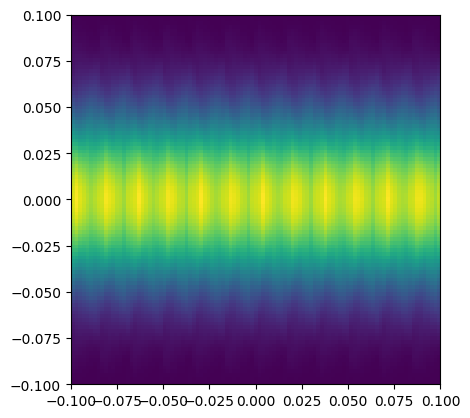

In [4]:
x = spectra.calc.x
y = spectra.calc.y

flux = spectra.calc.flux
plt.imshow(flux, extent=[x[0], x[-1], y[0], y[-1]])

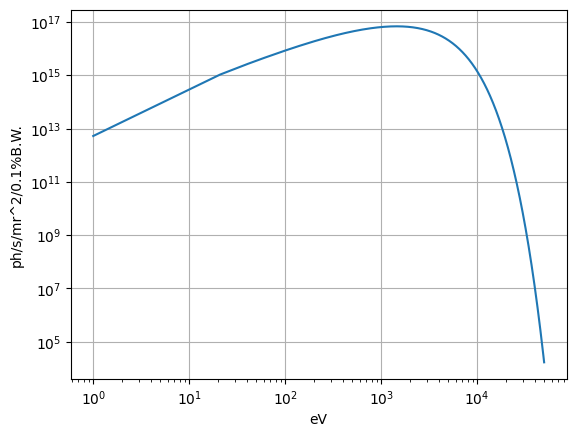

In [5]:
plt.yscale('log')
plt.xscale('log')
plt.plot(
    spectra.calc.energies,
    spectra.calc.brilliance,
)
plt.xlabel(spectra.calc.output_captions["units"][0])
plt.ylabel(spectra.calc.output_captions["units"][1])
plt.grid()

### Calc brilliance wiggler

In [8]:
period = 180
by_peak = 0.25
length = 1
gamma = 3e3/0.511

spectra = SpectraInterface()
spectra.accelerator.set_extraction_point('low_beta')

spectra.calc.source_type = spectra.calc.SourceType.wiggler
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.period = period
spectra.calc.by_peak = by_peak
spectra.calc.length = length
spectra.calc.distance_from_source = 20
spectra.accelerator.zero_emittance = False
spectra.accelerator.zero_energy_spread = False
spectra.calc.observation_angle = [0, 0]
spectra.calc.energy_range = [1, 50000]
spectra.calc.energy_step = 20
spectra.calc.set_config()
spectra.calc.run_calculation()

In [ ]:
plt.yscale('log')
plt.xscale('log')
plt.plot(
    spectra.calc.energies,
    spectra.calc.brilliance,
)
plt.xlabel(spectra.calc.output_captions["units"][0])
plt.ylabel(spectra.calc.output_captions["units"][1])
plt.grid()

In [10]:
period = 180
by_peak = 0.25
length = 1
gamma = 3e3/0.511

spectra = SpectraInterface()
spectra.accelerator.set_extraction_point('low_beta')

spectra.calc.source_type = spectra.calc.SourceType.wiggler
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.period = period
spectra.calc.by_peak = by_peak
spectra.calc.length = length
spectra.calc.distance_from_source = 20
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
# spectra.calc.observation_angle = [0, 0]
# spectra.calc.energy_range = [1, 50000]
# spectra.calc.energy_step = 20
spectra.calc.x_range = [-0.1, 0.1]
spectra.calc.y_range = [-0.1, 0.1]
spectra.calc.x_nr_pts = 201
spectra.calc.y_nr_pts = 201
spectra.calc.target_energy = 1000
spectra.calc.set_config()
spectra.calc.run_calculation()

In [ ]:
x = spectra.calc.x
y = spectra.calc.y

power = spectra.calc.flux
plt.imshow(power, extent=[x[0], x[-1], y[0], y[-1]])

### Loops

In [6]:
from spectrainterface.sources import Halbach, DELTA, Hybrid_Nd, Wiggler
from spectrainterface.sirius import SIRIUS
from spectrainterface.esrf import ESRF
B2 = SIRIUS.Sources.B2
BC = SIRIUS.Sources.BC

planar = Halbach(25, 1.2)
delta = DELTA(40, 1.0)
hybrid = Hybrid_Nd(18, 1.5)
wig = Wiggler(180, 1)
b2 = B2()
bc = BC()

spectra = SpectraInterface()
# spectra.accelerator = SIRIUS.StorageRing()
# spectra.accelerator.set_current_bsc()
# spectra.accelerator.set_extraction_point('low_beta')

sirius = SIRIUS.StorageRing()
esrf = ESRF.StorageRing()

spectra.accelerator = list()
spectra.accelerator.append(sirius)
spectra.accelerator.append(sirius)
spectra.accelerator.append(sirius)

spectra.accelerator.append(esrf)
spectra.accelerator.append(esrf)



spectra.sources = [planar, delta, b2, planar, delta]
extraction_points = ['low_beta', 'low_beta', 'b2', 'even_id', 'odd_id']

spectra.calc_brilliance_curve([1, 15], 13, emax=50000, extraction_points=extraction_points)

Calculation Status: Calculation Status: Calculation Status: Calculation Status: 

In [7]:
%matplotlib qt5
spectra.plot_brilliance_curve(process_curves=True, superp_value=20)

In [4]:
from spectrainterface.sources import Halbach, DELTA, Hybrid_Nd, Wiggler
from spectrainterface.sirius import SIRIUS
from spectrainterface.esrf import ESRF
B2 = SIRIUS.Sources.B2
BC = SIRIUS.Sources.BC

planar = Halbach(25, 1.2)
delta = DELTA(40, 1.0)
delta.polarization = 'hp'
delta.fields_ratio = 1


spectra = SpectraInterface()
# spectra.accelerator = SIRIUS.StorageRing()
# spectra.accelerator.set_current_bsc()
# spectra.accelerator.set_extraction_point('low_beta')

sirius = SIRIUS.StorageRing()
esrf = ESRF.StorageRing()

spectra.accelerator = list()
spectra.accelerator.append(sirius)
spectra.accelerator.append(sirius)

spectra.accelerator.append(esrf)
spectra.accelerator.append(esrf)

spectra.sources = [planar, planar, planar, delta]
betas = ["low_beta", "low_beta", 'odd_id', 'odd_id']

spectra.calc_flux_curve(
    energy_range=[1, 20000],
    harmonic_range=[1, 30],
    nr_pts_k=51,
    kmin=0.2,
    slit_shape="circslit",
    slit_acceptances=[[0.0, 0.01], [0.0, 0.08], [0.0, 0.01], [0.0, 0.08]],
    extraction_points=betas,
)

Calculation Status: Calculation Status: Calculation Status: Calculation Status: 

In [5]:
%matplotlib qt5
spectra.plot_flux_curve(process_curves=True, superp_value=20)